# 7. Project - Kaggle House Price Prediction

In [1]:
import os
import time
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms

## Import Data

In [2]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

Let's first check the size of the **training** and **test** sets:

In [3]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Let's **concatinate** the two dataset for preprocessing:

In [4]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## Data Preprocess

We first **standardize** all the numerical features:

$$x \leftarrow \frac{x - \mu}{\sigma}$$

Since the standardized data will have **mean value** of 0, we can set all the **missing values** to 0.

In [5]:
#obtain all the numerical features
numerical_features = all_features.dtypes[all_features.dtypes != 'object'].index
#apply standardization to each feature
all_features[numerical_features] = all_features[numerical_features].apply( lambda x: (x-x.mean()) / x.std() )
#replace missing values with 0
all_features[numerical_features] = all_features[numerical_features].fillna(0)

Then, we **encode** all the categorical variables with one-hot encoding.

By setting:

```python 
dummy_na = True
```

we consider **missing values** as a category.

In [6]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

Finally, we just need to convert the training and test features in **tensors**:

In [7]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## Training

We will first train a **linear model** as our baseline:


In [8]:
loss = nn.MSELoss()

n_inputs = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(n_inputs,1))
    return net

When predicting house prices, we are more interested in the **relative difference** $\frac{y - \hat{y}}{y}$ instead of the absolute difference $y - \hat{y}$.

Therefore, errors in predicting expensive and cheap house will have equivalent effects on our loss metric.

To do so, we take the **logarithm**:

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

We also need to clip the predictions with a **minimum** of 1 to stablize the logarithm result.

In [9]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [10]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [11]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    
    train_ls, test_ls = [], []
    
    train_iter = load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
            
        train_l = log_rmse(net, train_features, train_labels)     #training loss after the current epoch
        train_ls.append(train_l)
        #print(f'Epoch: ', epoch, ' Training Loss: ', train_l)
        if test_labels is not None:
            test_l = log_rmse(net, test_features, test_labels)    #test loss after the current epoch
            test_ls.append(test_l)
            
    return train_ls, test_ls

## K-Fold Cross-Validation

In [12]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k      #number of samples in each fold
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [13]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plt.plot(list(range(1, num_epochs + 1)), train_ls)
            plt.plot(list(range(1, num_epochs + 1)), valid_ls)
            plt.xlabel('epoch')
            plt.ylabel('rmse')
            plt.legend(['train', 'valid'])
            plt.yscale('log')
            plt.show()
        print(f'Fold {i+1}，training loss {float(train_ls[-1]):f}, validation loss {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

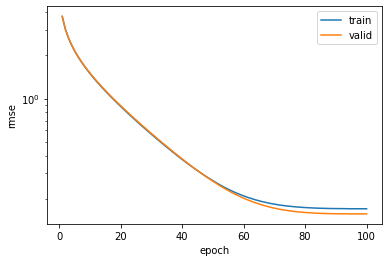

Fold 1，training loss 0.170248, validation loss 0.156830
Fold 2，training loss 0.162033, validation loss 0.189991
Fold 3，training loss 0.164666, validation loss 0.169071
Fold 4，training loss 0.168027, validation loss 0.154721
Fold 5，training loss 0.163469, validation loss 0.183018
5-Fold: average training loss0.165689, average validation loss: 0.170726


In [14]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-Fold: average training loss{float(train_l):f}, '
      f'average validation loss: {float(valid_l):f}')

## Make Predictions

In [15]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    plt.plot(list(range(1, num_epochs + 1)), train_ls)
    plt.xlabel('epoch')
    plt.ylabel('rmse')
    plt.legend(['train', 'valid'])
    plt.yscale('log')
    plt.show()
    print(f'Training loss：{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

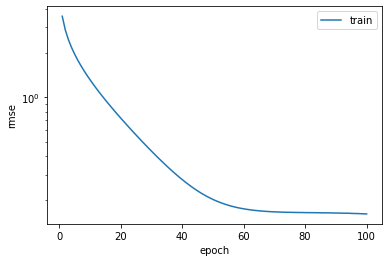

Training loss：0.162149


In [16]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)